# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [63]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [64]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [65]:
critics = pd.read_csv('C:/Users/jlpar/Documents/Springboard Data Files/critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [66]:
type(critics)

pandas.core.frame.DataFrame

In [4]:
critics.fresh.unique()

array(['fresh', 'rotten', 'none'], dtype=object)

In [67]:
x=len(critics.fresh=='fresh')
x2=len(critics.fresh=='rotten')
x3=len(critics.fresh=='none')

print(x,x2,x3)

15561 15561 15561


### Explore

In [69]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


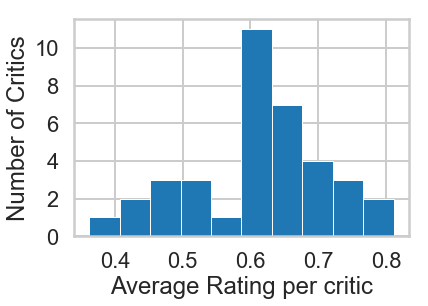

In [70]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

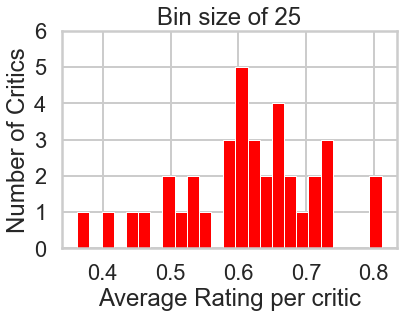

In [71]:
# Adding more bins to spread out the data
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=25, edgecolor='w', lw=1, color='red')
plt.title('Bin size of 25')
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 1, 2, 3, 4, 5, 6]);

Exercise: Look at the histogram above. Tell a story about the average ratings per critic. 
    What shape does the distribution look like? What is interesting about the distribution? 

Exercise Set 1 Questions 

The histogram displaying the number of Critics for the Average Rating per critic has a slight bi-modal distribution when there are a total of 10 bins in the histogram. There appears to be a very small peak from 0.3 to 0.5 and then the number of critics will start out at 11 and decline to 2 for the 0.8 average rating per critic.  Another Histogram was also generated and the data was merged into a total of 25 bins and the the peak was reduced from 11 down to 5.  The distribution of the data is more bell shaped or unimodal compared to the first graph.  The tail for the first histogram is to the right of the histogram or is positively skewed for the second peak.  

The 0.6 Average Rating per critic for both graphs has the highest rating with 6.5 and then when the rating per critic drops from 7.0 to 8.0, the critics drops down to 2 for the dataset.  The average rating per critique does not get any higher than 8 or lower than 3.5 in the dataset.  The critic attribute has three unique values and this is fresh, rotten and none for this category.  Each of these are equally weighted or have the same count from the data as shown in the (len) function above.  Each entry has 15,561 reviews.  The movie critics gave more of a positive review compared to one that is less than 0.6 for this dataset.

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [72]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [73]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [74]:
#your turn
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

#split the data set into a training and test set
xtrain, xtest, ytrain, ytest = train_test_split(X, y)

# train the classifier over the training set and test on the test set
mnb=MultinomialNB()
mnb.fit(xtrain, ytrain)
y_pred = mnb.predict(xtest)

In [75]:
# Print the accuracy on the test and training dataset
training_accuracy = mnb.score(xtrain, ytrain)
test_accuracy = mnb.score(xtest, ytest)


print('Training Accuracy = ', training_accuracy* 100)
print('Test Accuracy = ', test_accuracy * 100 )

Training Accuracy =  91.79091688089117
Test Accuracy =  77.04960164482138


In [76]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, y_pred))

[[ 987  540]
 [ 353 2011]]


In [77]:
from sklearn.metrics import classification_report
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.65      0.69      1527
           1       0.79      0.85      0.82      2364

   micro avg       0.77      0.77      0.77      3891
   macro avg       0.76      0.75      0.75      3891
weighted avg       0.77      0.77      0.77      3891



In [78]:
y_pred_prob = mnb.predict_proba(xtest)[:,1]

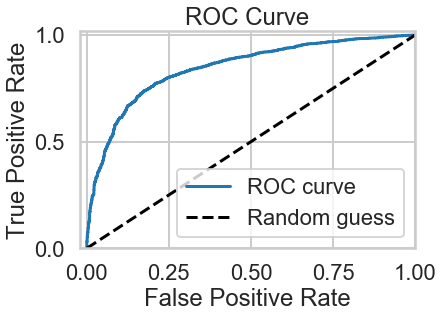

In [79]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, thresholds = roc_curve(ytest, y_pred_prob)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

What do you notice? Is this a good classifier? If not, why not?

Classification of the model can be determined by many factors and Naive Bayes is a good model to use because it is quick and has reliable estimations of the probability class (when the assumption of independence is true).  The training accuracy is around 92% and then the test accuracy drops down to 77% for this model.  Some of the literature states that if the ROC curve is above 0.70 then it is a good classifier and this model did a nice job in separating the true positives from the false positives. The AUC seems to be a good performance indicator in the first model that we have created for Naive Bayes.  

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [80]:
# convert the compact array to a regular array
X = X.toarray()

# convert array to pandas dataframe
xdf = pd.DataFrame(X)

# Sum the words in the columns and create and new column called percentage.  
sums = xdf.sum(axis=0)
xdf['percentage'] = 0.0

# calculate the percentage of words that appear in i (fewer documents for the # of documents (rows))
for i in range(len(xdf) - 1):
    xdf.loc[i,'percentage'] = sums[sums <= i].count()/float(len(sums))

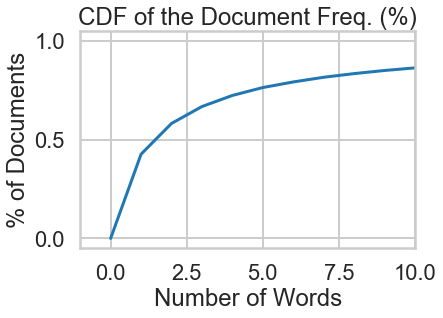

In [81]:
# plot the percentages versus i
plt.plot(xdf.index, xdf.percentage)
plt.xlim(xmin = -1,xmax = 10)

plt.title('CDF of the Document Freq. (%)')
plt.ylabel('% of Documents')
plt.xlabel('Number of Words')
plt.show()

Exercise: Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?

The alpha is a value that is choosen instead of having zeros on the probability computations.  The graph was created to only show the values for the words that were less than ten for the % of the documents in the dataset.  The graph or curve begins to plateau or flatten out round 0.75 to 0.8 on the CDF of Document Frequency.  The steepest area of the curve is a value of less than one on the curve and is around 0.4.  This is an arbitrary value, but 0.4 will be the min_df value and around 0.85 the curve is flatten, out so this would be a good value for max_df.

In [82]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [83]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [84]:
from sklearn.model_selection import train_test_split

_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]

In [85]:
# Exercise: Using the skeleton code below, find the best values of the parameter `alpha`, 
# and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` 
# function above with the `log_likelihood` function for scoring.

from sklearn.naive_bayes import MultinomialNB

#the grid of parameters
alphas = [.1, 1, 5, 10, 50]

# min_dfs values
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]


#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas: 
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df=min_df)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
    # your turn
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df

In [86]:
print("best alpha is:", (best_alpha))
print("best min_df is:",(best_min_df))

best alpha is: 5
best min_df is: 0.001


In [87]:
## Replacing the min_df with my choosen value of 0.4 to see the accuracy results

vectorizer = CountVectorizer(min_df= 0.4)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

mnb2 = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = mnb2.score(xtrain, ytrain)
test_accuracy = mnb2.score(xtest, ytest)

print('Training Accuracy: ', (training_accuracy* 100))
print('Test Accuracy : ',(test_accuracy* 100))

Training Accuracy:  61.40501177982437
Test Accuracy :  60.650018362100624


Exercise: What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?
The log likelihood is a tool that is used in statistics for summerizing the data's evidence about the unkown parameters.  The parameter values are there to maximize the likelihood that the process described by these model produced from the data
were actually observed (Towards Data Science Article).  The goal is to maximize these values. 

Exercise: Without writing any code, what do you think would happen if you choose a value of  𝛼  that is too high?
Stack overflow states that the alpha is a smoothing parameter and when the alpha increases in value the model will be more bias to the class in the dataset which has more records.  The model will underfit the data as the alpha increases in value.

The best alpha was 5 and the min_df that I choose from the graph was 0.4 and these two values were used to test the model.  The interesting results from the model is both the training and test accuracy levels are almost identical and will average out to be 61% when rounded up.  The accuracy values for both the training and testing resuls were lower with my choosen value of 0.4 when compared to the first model.  The min_df function is to high as shown from the best values for the alpha and min_df.  


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [88]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.799315
Accuracy on test data:     0.713000


In [89]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2038 2240]
 [ 886 5728]]


Exercise: Using the best value of `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?

The test accuracy decreased from a value of 77.5 down to 72.2 and is actually a reduction in value when the best alpha was used for this model.  The training accuracy also decreased in value from 91 down to about 80 and there is less of a difference between the training and testing accuracy for the model. The model did not overfit as much on the training data compared to the previous model, but the test accuracy results are very similar. 

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [90]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
              brings 0.87
            powerful 0.87
         masterpiece 0.86
             perfect 0.86
             complex 0.85
               witty 0.83
           effective 0.83
           brilliant 0.83
                form 0.83
         performance 0.82
Bad words	     P(fresh | word)
              cliche 0.30
               tired 0.30
             unfunny 0.30
               flick 0.29
             problem 0.29
           formulaic 0.29
             neither 0.29
             attempt 0.29
              trying 0.25
                none 0.23


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

Exercise: Why does this method work? What does the probability for each row in the identity matrix represent. 

The row from the matrix is the probability a word will be with this location on the matrix and is designated as i for this example.  The row will only have one word or term designated to this array and the trained classifier will make predictions about the probability of finding this term in this location which is designated as p.  The good word above predicts that "powerful" has an 87% chance of being found on this location while "none" only has a 23 chance for being classified as a bad word.  

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [91]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
Though based on an original and respected novel, Hyams' horror thriller comes across as a pastiche of the genre's conventions as evident in major pictures of the past two decades, such as Jaws and the first two Alien films.

Benefits from a lively lead performance by the miscast Denzel Washington but doesn't come within light years of the book, one of the greatest American autobiographies.

With the exception of Miss Streep's performance, the pleasures of Out of Africa are all peripheral -- David Watkin's photography, the landscapes, the shots of animal life -all of which would fit neatly into a National Geographic layout.

The plot of The Glimmer Man involves not only the Family Man but Our Evil Secret Government, the Russian Mafia and Rich Powerful Politicians -- the three stooges of action cinema in the '90s.

Directed with composure, but no great fervour, the film's conspicuously uninterested in American football, and much con

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [94]:
testtext = ['This movie is not remarkable, touching, or superb in any way']
xtest = vectorizer.transform(testtext)
predict = clf.predict_proba(xtest)
predict

array([[0.13276505, 0.86723495]])

The array shows that almost 13 % of the words have a rotten score compared to almost 87 % that have been classified as fresh 
according to the model that is used in this example.  I can see that the word "not" is a negative word, but also it is not touching or not surperb and the rotten rating should be higher because at least four out of 11 words are more negative than positive in this example.  Remarkable and superb are positive words when they are not preceded with the word "not".

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [95]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

In [96]:
Xtfidf.shape

(15561, 22125)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

Several models were created to improve model performance and these are:  SGD Classifier(), Perceptron(), RandomForestClassifier(), SVC and DecisionTreeClassifier() for this Enrichment exercise.  The models are listed in the order
of performance and the SGDClassifier model had the best test accuracy score compared to the other five models and the training accuracy was the third highest for all these models.  The Training Accuracy was 81% and the Test Accuracy was around 69 percent for this model.  These values are very similar to the previous Multinominal Model that used the best parameters and the training accuracy for this model was 80% and the Test Accuracy was 72 percent.  These models are very similar in thier results and the literature does state that the Naive Bayes Classifier does a good job, if assumptions are true for the data set, in providing a straightforward and interpretable model that has minimal tunable parameters.  Also, the worst model that is also very interpratable is the Decesion Tree Model that overtrained on the training data (99%) and did not predict well on the test data (60%).

In [97]:
from sklearn.linear_model import SGDClassifier 

vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask] 
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

# use default settings

clf = SGDClassifier().fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print('Training Accuracy: ', (training_accuracy* 100))
print('Test Accuracy : ',(test_accuracy* 100))

Training Accuracy:  80.74534161490683
Test Accuracy :  67.63679764965111


In [98]:
# Confusion Matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[1923 2355]
 [1170 5444]]


In [99]:
# Perceptron
from sklearn.linear_model import Perceptron

vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask] 
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

# use default settings

clf = Perceptron().fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print('Training Accuracy: ', (training_accuracy* 100))
print('Test Accuracy : ',(test_accuracy* 100))

Training Accuracy:  81.751981152281
Test Accuracy :  68.35291957399926


In [100]:
from sklearn.ensemble import RandomForestClassifier

vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

# use default settings for Random Forest Classifier
clf = RandomForestClassifier().fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print('Training Accuracy: ', (training_accuracy* 100))
print('Test Accuracy : ',(test_accuracy* 100))

Training Accuracy:  98.62925680017133
Test Accuracy :  65.08446566287184


In [101]:
from sklearn.svm import SVC
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask] 
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

# use default settings
clf = SVC().fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print('Training Accuracy: ', (training_accuracy* 100))
print('Test Accuracy : ',(test_accuracy* 100))

Training Accuracy:  61.4264296423217
Test Accuracy :  60.723466764597866


In [102]:
from sklearn.tree import DecisionTreeClassifier

vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask] 
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

# use default settings

clf = DecisionTreeClassifier().fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print('Training Accuracy: ', (training_accuracy* 100))
print('Test Accuracy : ',(test_accuracy* 100))

Training Accuracy:  99.67873206254015
Test Accuracy :  60.67756151303709
